<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/boosting_tree_quantile_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantile Regression using boosting tree methods like xgboost, lightgbm and gradient boosting tree from scikit-learn

Note that lightgbm and scikit-learn gradient boosting method already have quantile regression implemented. In this notebook, we will show that how to create equivalent results using customized loss function for xgboost and lightgbm.


The fundamental idea is to use quantile loss, which is a skewed L1 loss

$L(\xi) = \begin{cases} \alpha \xi & \text{for } \xi>0 \\ (1-\alpha) |\xi| & \text{for } \xi<0 \end{cases}$,
where $\xi$ is the residual, $0<\alpha<1$.

When $\alpha=0.5$, the loss becomes standard L1 loss, and the corresponding loss is essentially looking for median.

When $\alpha>0.5$, the loss is heavily penalizing positive residual, and hence will result in a less than medium value. Detailed calculation can show that the expected result is $(1-\alpha)$-quantile of the possible distribution of $y$. Therefore, setting $\alpha=0.95$ is equivalently to search for bottom 5% percentile.

Similarly, when $\alpha<0.5$, the algorithm will be searching for $(1-\alpha)$-quantile again, on the upper side.

Although above loss will give quantile loss in exact mathematical derivation, in practice, will lead to poor performance because its non-smooth behavior (it is only C0 smooth). The first derivative of the loss respect to the residual is a two-piece constant function. And its hessian is ill defined(delta function that is infinity at $\xi=0$ and $0$ everywhere else).

To resolve this issue, we will be using a "soft" huber loss. The vanilla huber loss is given as
$L(\xi) = \begin{cases} \xi^2/2 & \text{for } |\xi|<\delta \\ \delta(|\xi|-\delta/2) & \text{for } |\xi|>\delta \end{cases}$, where $\delta$ is a small positive value. The basic idea of huber loss is that it behaves as standard L2-loss when the residual is small, and behaves like L1 loss when the residual is big. The benefit of using huber loss is that it is C1 smooth everywhere: not only the loss value itself is continous, but its derivative is aso continuous. As $\delta\rightarrow+0$, huber loss becomes L1 loss; as $\delta\rightarrow+\infty$, huber loss behaves as L2 loss. Dependent on the problem, $\delta$ is usually chosen to be similar to the same level of intrinsic error of $y$. Huber loss, due to its L1 behavior for big residual, is more robust than L2 loss to outliers as it wouldn't try to only focus on the big loss terms.

The vanila huber loss is symmetric around $\xi=0$. To make it asymmetric like quantile loss, we use a "soft" huber loss function. First, define
$$\delta_1 = (1-\alpha)\delta$$
$$\delta_2 = \alpha\delta$$


The soft huber loss is as follow
$L(\xi) = \begin{cases} \delta_1(|\xi|-\delta_1/2) & \text{for } \xi<-\delta_1 \\
\xi^2/2 & \text{for } -\delta_1\leq \xi\leq\delta_2 \\ \delta_2(|\xi|-\delta_2/2) & \text{for } \xi>\delta_2 \end{cases}$

The gradient of soft huber loss with respect to residual is
$L' = \begin{cases} -\delta_1=-(1-\alpha)\delta & \text{for } \xi<-\delta_1 \\
\xi & \text{for } -\delta_1\leq \xi\leq\delta_2 \\ \delta_2=\alpha\delta & \text{for } \xi>\delta_2 \end{cases}$
and the Hessian is
$L'' = \begin{cases} 0 & \text{for } \xi<-\delta_1 \\
1 & \text{for } -\delta_1\leq \xi\leq\delta_2 \\ 0 & \text{for } \xi>\delta_2 \end{cases}$

Note that this is still not very ideal as xgboost can be greatly accelerated with a meaning full Hessian. The Hessian of this soft huber loss is only helpful for small errors, as it becomes identical to MSE loss for small $\xi$.



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

import lightgbm

from functools import partial

np.random.seed(1)

In [0]:
## sample data from a function

def get_y(x, err = 1, fun='sinc'):
    e = np.random.randn(*x.shape)*err
    y = x*np.sin(x)
    return y+e

def get_data(n = 1000, err = 0.1, split=0.2):
    x = np.linspace(0,10,n)
    y = get_y(x, err = err)
    y_exact = get_y(x, err = 0)

    ind = np.arange(n)
    np.random.shuffle(ind)
    ind_split = int(n*(1-split))
    ind_train = np.sort(ind[:ind_split])
    ind_test = np.sort(ind[ind_split:])

    return x[ind_train].reshape(-1,1), y[ind_train], x[ind_test].reshape(-1,1), y[ind_test], x, y_exact

In [0]:
def plot_results(x,y_exact,xtrain, ytrain, xtest, ytest, y_pred, y_upper = None, y_lower = None):
    plt.plot(x,y_exact,'b--',label='exact')
    plt.plot(xtrain, ytrain, '.', markersize=10, label=u'train')
    plt.plot(xtest, ytest, 'o', markersize=10, label=u'test')
    plt.plot(xtest, y_pred, 'r-', label=u'Prediction')
    if y_upper is not None and y_lower is not None:
        plt.plot(xtest, y_upper, 'k-')
        plt.plot(xtest, y_lower, 'k-')
        plt.fill(np.concatenate([xtest, xtest[::-1]]),
                np.concatenate([y_upper, y_lower[::-1]]),
                alpha=.1, fc='b', ec='None', label='90% prediction interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left')

In [0]:
def soft_quantile_loss_wrapper(alpha = 0.5, delta = 0.25):
    '''
    use asymmetric huber loss
    d1 = delta*(1-alpha)
    d2 = delta*alpha

    L = 0.5*e^2        if   -d1<e<d2
        d1*(|e|-d1/2)  if e<-d1
        d2*(|e|-d2/2)  if         d2<e

    g = e              if   -d1<e<d2
        -d1            if e<-d1
        d2             if         d2<e

    H = 1              if   -d1<e<d2
        0              if e<-d1
        0              if         d2<e
    '''
    d1 = delta*(1-alpha)
    d2 = delta*alpha

    def soft_quantile_loss(y_true, y_pred):
        r = (y_true - y_pred).astype("float")
        grad = np.where(-r<-d1, -d1, -r)
        grad = np.where(-r<d2, grad, d2)
        
        hess = np.where((-r>-d1) & (-r<d2), 1, 0)

        return grad, hess
    
    return soft_quantile_loss

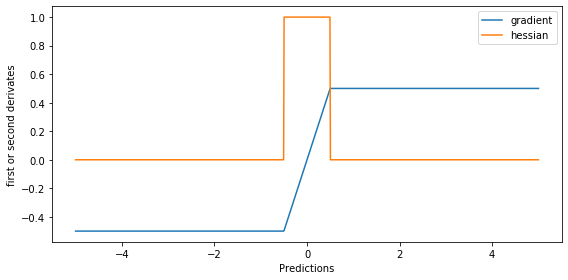

In [5]:
y_pred = np.linspace(-5,5,1000)
y_true = np.repeat(0,1000)
grad, hess = soft_quantile_loss_wrapper(alpha=0.5,delta=1)(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

## Fit

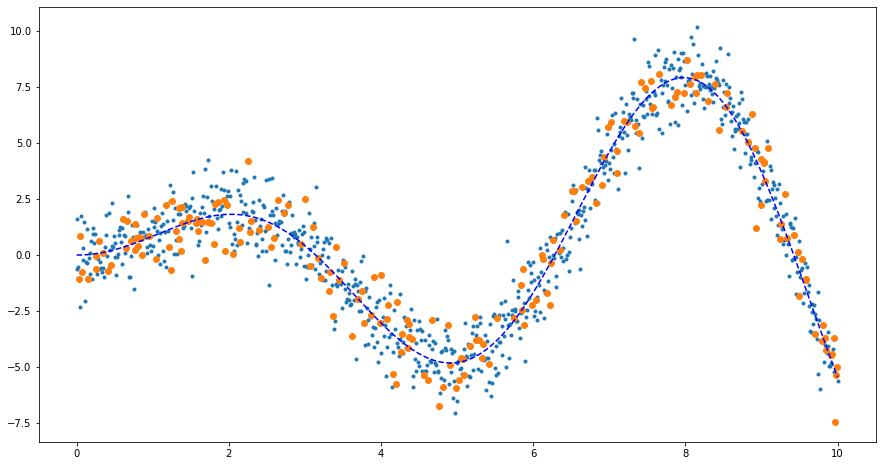

In [6]:
n = 1000
err = 1

xtrain, ytrain, xtest, ytest, x, y_exact = get_data(n = n, err = err, split = 0.2)
plt.figure(figsize=(15,8))
plt.plot(xtrain,ytrain,'.')
plt.plot(xtest,ytest,'o')
plt.plot(x,y_exact,'b--')


In [0]:
alpha=0.95
delta = 0.2

In [0]:
res = {}

In [9]:
xg_param = {'n_estimator': 100, 'max_depth':6, 'learning_rate': 0.2, 'tree_method':'exact'}
xg_param = {}

regressor = XGBRegressor(objective = soft_quantile_loss_wrapper(0.5, delta), **xg_param)
y_pred = regressor.fit(xtrain,ytrain).predict(xtest)

regressor = XGBRegressor(objective = soft_quantile_loss_wrapper(alpha, delta), **xg_param)
y_lower = regressor.fit(xtrain,ytrain).predict(xtest)

regressor = XGBRegressor(objective = soft_quantile_loss_wrapper(1-alpha, delta), **xg_param)
y_upper = regressor.fit(xtrain,ytrain).predict(xtest)

res['xg'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'xgboost - asymmetric huber'}

[05:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
gb_param = {'n_estimators':100, 'max_depth':8, 'learning_rate':.1, 'min_samples_leaf':9,'min_samples_split':9}
clf = GradientBoostingRegressor(loss='quantile', alpha=alpha)

y_lower = clf.fit(xtrain, ytrain).predict(xtest)

clf.set_params(alpha=1.0 - alpha)
y_upper = clf.fit(xtrain, ytrain).predict(xtest)

clf.set_params(loss='ls')
y_predict = clf.fit(xtrain, ytrain).predict(xtest)

res['gb'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'gb tree - built-in quantile'}

In [0]:
#lgbm_param = {'num_leaves':100, 'max_depth': 10, 'n_estimators': 250}
lgbm_param = {}
#lgbm_param = {'num_leaves': 200, 'max_depth':6, 'learning_rate': 0.2, 'gamma': 0.5, 'tree_method':'exact'}


gbm = lightgbm.LGBMRegressor(objective=soft_quantile_loss_wrapper(0.5, delta), **lgbm_param)
gbm.fit(xtrain, ytrain) 
y_pred = gbm.predict(xtest)
gbm = lightgbm.LGBMRegressor(objective=soft_quantile_loss_wrapper(alpha), **lgbm_param)
gbm.fit(xtrain, ytrain) 
y_lower = gbm.predict(xtest)
gbm = lightgbm.LGBMRegressor(objective=soft_quantile_loss_wrapper(1-alpha, delta), **lgbm_param)
gbm.fit(xtrain, ytrain) 
y_upper = gbm.predict(xtest)

res['lightgbm_1'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'lightgbm - asymmetric huber'}


In [0]:
gbm = lightgbm.LGBMRegressor(objective='quantile', alpha = 0.5, **lgbm_param)
y_pred = gbm.fit(xtrain, ytrain).predict(xtest)

gbm = lightgbm.LGBMRegressor(objective='quantile', alpha = alpha, **lgbm_param)
y_lower = gbm.fit(xtrain, ytrain).predict(xtest)

gbm = lightgbm.LGBMRegressor(objective='quantile', alpha = 1-alpha,  **lgbm_param)
y_upper = gbm.fit(xtrain, ytrain).predict(xtest)

res['lightgbm_2'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'lightgbm - built-in quantile loss'}


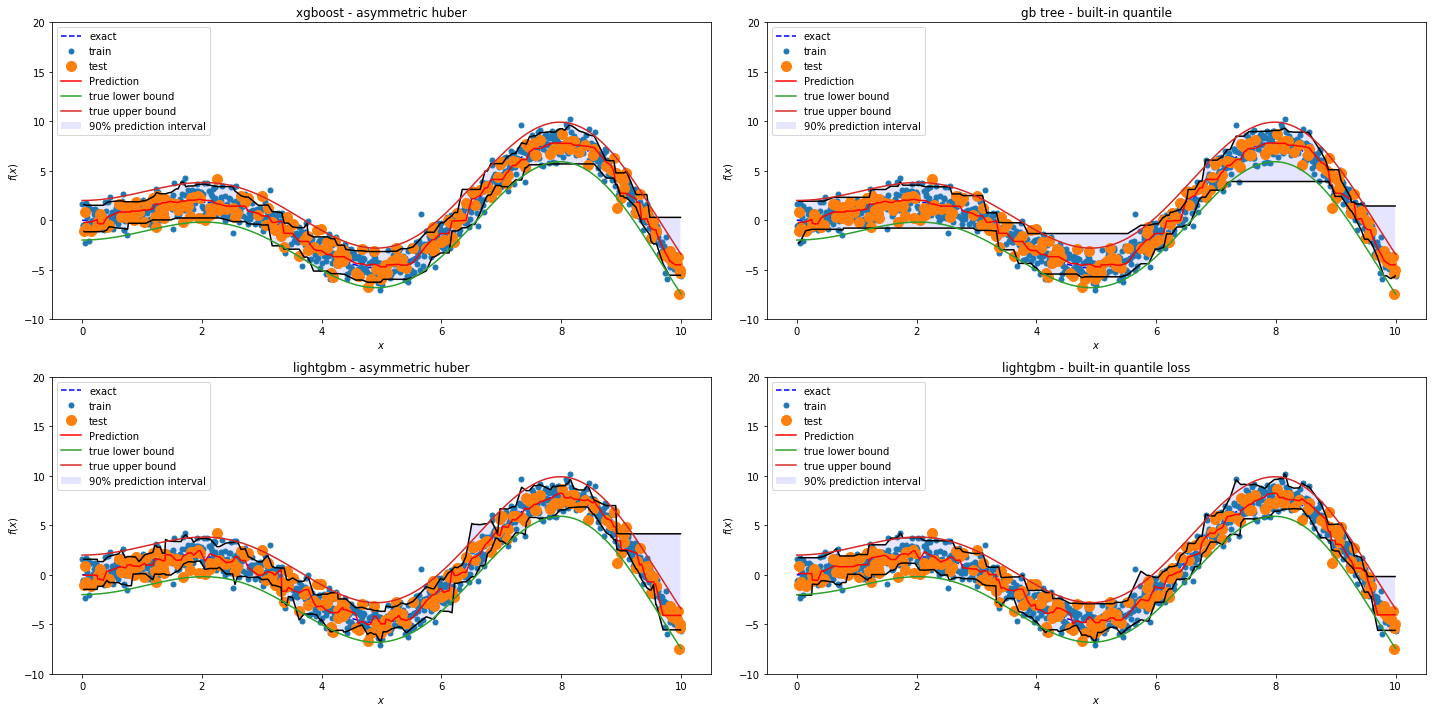

In [13]:
plt.figure(figsize=(20,10))
for i, key in enumerate(res):
    plt.subplot(2,len(res)//2,i+1)
    y_pred, y_upper, y_lower, title = res[key]['pred'], res[key]['upper'], res[key]['lower'], res[key]['title'] 
    plot_results(x, y_exact, xtrain, ytrain, xtest, ytest, y_pred, y_upper, y_lower)
    plt.plot(x,y_exact-err*2, label = 'true lower bound')
    plt.plot(x,y_exact+err*2, label = 'true upper bound')
    plt.legend()
    plt.title(title)
plt.tight_layout()